# Neuronale Netzwerke - Bildsegmentierung
---

## 1. Einführung in Segmentierung

Bisher haben wir ein/mehrere Netzwerke verwendet, welche uns helfen, __Klassifizierungsprobleme__ zu lösen, sprich: Sei ein Eingangssignal, z.B. ein Bild gegeben, gibt uns das Netzwerk eine zugehörige Klasse, zum Beispiel die im Bild vorhandene Zahl.

Allerdings ist das nicht immer eine Lösung zu unseren Problemen. Wenn medizinische Bilder gestellt werden, reicht es nicht immer aus zu sagen ob sich in einem Bild etwas befindet. Meist muss gezeigt werden, wo in diesem Bild sich das Objekt befindet, sprich: Welcher Pixel gehört zu dem Zielobjekt und welcher nicht. Wir generieren also eine Maske, die uns anzeigen soll wo in dem Bild sich die Objekte befinden. Solche Probleme fassen wir als __Segmentierungsprobleme__ zusammen.

Ein Beispiel (entnommen https://wiki.tum.de/display/lfdv/Image+Semantic+Segmentation):

<img src="Bilder/sms.png"> 

## 2. Leberdatensatz und -generator

Um uns mit der Problematik auseinanderzusetzen, wollen wir anhand des beiliegenden Datensatzes ein Netzwerk trainieren, welches Leberpixel aus Computertomographiebildern segmentiert.  

Hierfür bedienen wir uns einer Stichprobe des __LiTS__ (_Liver in Tumor Segmentation_) Datensatzes, siehe https://competitions.codalab.org/competitions/17094. Es stellt Trainings-CT-Bilder der abdominalen Region zur Verfügung inklusive von Fachärzten generierten Masken, gezeigt hier:

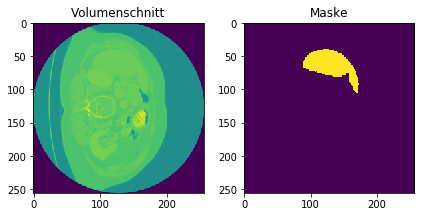

In [3]:
import matplotlib.pyplot as plt
import os, numpy as np

beispiel_schnitt = os.getcwd()+'/LeberDaten/Volumina/volume-0/slice-50.npy'
beispiel_maske   = os.getcwd()+'/LeberDaten/Masken/volume-0/slice-50.npy'

beispiel_schnitt = np.load(beispiel_schnitt)
beispiel_maske   = np.load(beispiel_maske)

f,ax = plt.subplots(1,2)
ax[0].imshow(beispiel_schnitt)
ax[0].set_title('Volumenschnitt')
ax[1].imshow(beispiel_maske)
ax[1].set_title('Maske')
f.tight_layout()
plt.show()

Hierbei ist es für den späteren Verlauf sinnvoll, die Eingangsdaten etwas zu bereinigen und unnötige Informationen zu entfernen. Zudem verwenden CT-Scans `Hounsfield Units (HU)`, siehe https://en.wikipedia.org/wiki/Hounsfield_scale. Diese müssen idealerweise noch standardisiert werden (Mittelwert 0, Standardabweichung 1), damit das Netzwerk einfacher lernen kann.
Folgende Funktion entfernt hierfür Fett- und andere unnötige Gewebepixel und berechnet die Standardisierung, indem im Vorhinein der Mittelwert und die Standardabweichung über den gesamten Datensatz berechnet wurden:

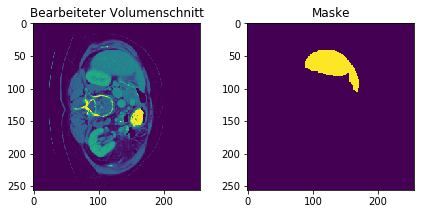

In [4]:
def set_bounds(image,MIN_BOUND,MAX_BOUND):
    """
    Limitiere ein Bild im Intervall [MIN_BOUND, MAX_BOUND].
    """
    return np.clip(image,MIN_BOUND,MAX_BOUND)


def standardize(image,use_bd=True,zero_center=True,unit_variance=True):
    """
    Berechne Standardisierung bzw. Normalisierung und verwenden HU-Grenzen
    um unnötige Gewebepixel zu entfernen.
    """
    PIXEL_MEAN = 0.1021
    PIXEL_STD  = 0.19177
    
    if not use_bd:
        MIN_BOUND = np.min(image)
        MAX_BOUND = np.max(image)
    else:
        MIN_BOUND = -100.0 #Everything below: Water
        MAX_BOUND = 400.0
        image = set_bounds(image,MIN_BOUND,MAX_BOUND)
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image = np.clip(image,0.,1.)
    if zero_center:
        image = image - PIXEL_MEAN
    if unit_variance:
        image = image/PIXEL_STD
    return image


f,ax = plt.subplots(1,2)
ax[0].imshow(standardize(beispiel_schnitt))
ax[0].set_title('Bearbeiteter Volumenschnitt')
ax[1].imshow(beispiel_maske)
ax[1].set_title('Maske')
f.tight_layout()
plt.show()

Das einzige was nun fehlt ist unser Datensatzgenerator. Hierfür bedienen wir uns wieder dem PyTorch `Dataset`. Wichtig ist nur, dass wir bei Bilddaten wieder im Auge behalten müssen, dass die herausgegebenen Daten die Form `(batchsize x channels x width x height)` besitzen müssen. In unserem Fall ist `channels`, also die Zahl der Bildkanäle, gleich 1, da wir ein Graustufenbild haben.

In [6]:
from torch.utils.data import Dataset

class LiverDataset(Dataset):
    def __init__(self, is_val=False):
        self.datapath = os.getcwd()+'/LeberDaten'
        self.volumes  = os.listdir(self.datapath+'/Volumina')
        
        self.images   = [[x for x in os.listdir(os.getcwd()+'/LeberDaten/Volumina/'+vol)] for vol in self.volumes]
        self.images   = [os.getcwd()+'/LeberDaten/Volumina/'+vol+'/'+x for vol,y in zip(self.volumes,self.images) for x in y]
        
        self.masks    = [[x for x in os.listdir(os.getcwd()+'/LeberDaten/Masken/'+vol)] for vol in self.volumes]
        self.masks    = [os.getcwd()+'/LeberDaten/Masken/'+vol+'/'+x for vol,y in zip(self.volumes,self.masks) for x in y]        

        ref_len = int(len(self.images)*0.8)
        if is_val:
            self.images = self.images[ref_len:]
            self.masks  = self.masks[ref_len:]
        else:
            self.images = self.images[:ref_len]
            self.masks  = self.masks[:ref_len]
            
    def __getitem__(self, idx):
        return standardize(np.expand_dims(np.load(self.images[idx]),axis=0)), np.expand_dims(np.load(self.masks[idx]),axis=0)
    
    def __len__(self):
        return len(self.images)

ModuleNotFoundError: No module named 'torch'

In [6]:
import torch.utils.data as data
trainliverdataset    = LiverDataset()
valliverdataset      = LiverDataset(is_val=True)

TrainLiverDataloader = data.DataLoader(trainliverdataset, batch_size=1, num_workers=4, shuffle=True)
ValLiverDataloader   = data.DataLoader(valliverdataset, batch_size=1, num_workers=0, shuffle=False)

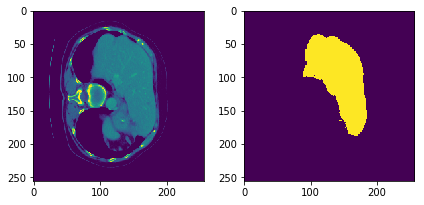

In [7]:
### Test unseres Datengenerators
check = trainliverdataset[300]
f,ax = plt.subplots(1,2)
ax[0].imshow(check[0][0,:])
ax[1].imshow(check[1][0,:])
f.tight_layout()
plt.show()

Mit unserem Generator scheint alles zu klappen!

Entsprechend wollen wir uns nun dem Netzwerk widmen.

__Als Randnotiz:__ Insgesamt bedienen wir uns 3 Volumen aus dem gesamten Datensatz um die Rechnungsdauer im Rahmen das Machbaren zu halten. Unser Validierunsdatensatz verwendet Schnitte aus Volumen in denen auch trainiert wird - das sollte in realen Anwendungen stets vermieden werden, um aussagekräftige Validierungsergebnisse zu erhalten. In unseren Fall ist es aber für Lernzwecke ausreichend.

---

## 3. UNet

Das U-Net oder UNet ist eine von Prof. Ronneberger und seiner Arbeitsgruppe in Freiburg entwickelte Netzwerkstruktur, welche heutzutage die Grundlage für die meisten Segmentierungsnetze stellt (https://arxiv.org/abs/1505.04597), und hat folgende Struktur:

<img src="Bilder/unet.png">

Dem aufmerksamen Betrachter entgeht nicht, dass die Struktur dem Buchstaben `U` ähnelt, daher auch der Name. Zudem ist die linke Seite des `U`'s nichts weiter als ein normales CNN, welches wir schon aus den vorherigen Tutorials kennen. 

Die einzige Unterscheidung findet sich hier in den horizontalen Verbindungen: Finale _Featuremaps_ in jedem Segment, eingeteilt durch die Verwendung von _MaxPool_-Schichten, werden kopiert und dem rechten Arm weitergegeben, zu welchem wir nun kommen.

Dieser folgt in seiner Struktur einem umgekehrten CNN. Anstelle dass das Netzwerk Eigenschaften aus einem Bild zu extrahieren lernt wie es die linke Seite macht, lernt die Rechte Seite aus Eigenschaften ein Bild zu generieren, welches final die Zielmaske stellen soll.

Allerdings werden hier anstelle der _MaxPooling_-Schichten sogenannte __transposed convolutional layer__ verwendet. Diese sind aufgebaut wie normale CNN-Schichten, allerdings haben die Gewichte eine transponierte Struktur gegenüber den normalen Schichten, sodass bei Anwendung eine "Vergrößerung" erlernt wird, anstelle der Extraktion bestimmter Bildeigenschaften.

Die Ausgabe dieser Schichten werden kombiniert mit den Pässen kommend von der linken Seite um das erstellen der Masken zu verbessern.

Abschließend wird die letzte _Featuremap_ durch eine `Sigmoid` bzw. bei mehreren Klassen `Softmax`-Aktivierung geschickt, um eine pro-Pixep-Wahrscheinlichkeitsverteilung zu gewährleisten.

Ein kleines UNet, welches wir verwenden wollen, hat in PyTorch folgende Struktur:

In [8]:
import torch.nn as nn

class UNetClass(nn.Module):
    def __init__(self):
        super(UNetClass,self).__init__()
        self.d_conv1_1 = nn.Conv2d(1, 10,  kernel_size=3, padding=1) # 26x26
        self.d_conv1_2 = nn.Conv2d(10, 20, kernel_size=3,padding=1) # 24x24
        self.d_conv1_3 = nn.Conv2d(20, 20, kernel_size=3,padding=1) # 24x24
        
        self.d_conv2_1 = nn.Conv2d(20, 40, kernel_size=3,padding=1) # 12x12
        self.d_conv2_2 = nn.Conv2d(40, 40, kernel_size=3,padding=1) # 12x12
        
        self.d_conv3_1 = nn.Conv2d(40, 80, kernel_size=3,padding=1) # 12x12
        self.d_conv3_2 = nn.Conv2d(80, 80, kernel_size=3,padding=1) # 12x12
        
        self.b_conv1_1 = nn.Conv2d(80, 160,  kernel_size=3,padding=1) # 6x6        
        self.b_conv1_2 = nn.Conv2d(160, 160, kernel_size=3,padding=1) # 6x6                

        self.t_conv1_1 = nn.ConvTranspose2d(160,80,4,2,1)
        self.u_conv1_1 = nn.Conv2d(160, 80, kernel_size=3, padding=1)  # 26x26
        self.u_conv1_2 = nn.Conv2d(80, 80,  kernel_size=3,padding=1) # 24x24
       
        self.t_conv2_1 = nn.ConvTranspose2d(80,40,4,2,1)
        self.u_conv2_1 = nn.Conv2d(80, 40, kernel_size=3,padding=1)  # 12x12
        self.u_conv2_2 = nn.Conv2d(40, 40, kernel_size=3,padding=1)  # 12x12
        
        self.t_conv3_1 = nn.ConvTranspose2d(40,20,4,2,1)
        self.u_conv3_1 = nn.Conv2d(40, 20, kernel_size=3,padding=1)  # 12x12
        self.u_conv3_2 = nn.Conv2d(20, 1,  kernel_size=3,padding=1)  # 12x12
        
        self.out_act = nn.Sigmoid()
        
        
    def forward(self, x):
        x = F.relu(self.d_conv1_1(x))
        x = F.relu(self.d_conv1_2(x))
        pass_1 = x = F.relu(self.d_conv1_3(x))       
        x = F.max_pool2d(x,2)
        
        x = F.relu(self.d_conv2_1(x))
        pass_2 = x = F.relu(self.d_conv2_2(x))
        x = F.max_pool2d(x,2)

        x = F.relu(self.d_conv3_1(x))
        pass_3 = x = F.relu(self.d_conv3_2(x))
        x = F.max_pool2d(x,2)
        
        x = F.relu(self.b_conv1_1(x))
        x = F.relu(self.b_conv1_2(x))
        
        x = torch.cat([pass_3,self.t_conv1_1(x)],dim=1)
        x = F.relu(self.u_conv1_1(x))
        x = F.relu(self.u_conv1_2(x))
        
        x = torch.cat([pass_2,self.t_conv2_1(x)],dim=1)
        x = F.relu(self.u_conv2_1(x))
        x = F.relu(self.u_conv2_2(x))
                
        x = torch.cat([pass_1,self.t_conv3_1(x)],dim=1)
        x = F.relu(self.u_conv3_1(x))
        x = F.relu(self.u_conv3_2(x))
        
        return self.out_act(x)

Mit diesem Netzwerk wollen wir nun ein Netzwerk lernen, welches uns Leberpixel segmentiert!

## 4. Eigene Kostenfunktionen

Bisher haben wir uns stets der `CrossEntropy`-Kostenfunktion bedient. Es stellt sich aber oftmals bei Segmentierungsproblemen heraus, dass die Pixel die uns interessieren (zum Beispiel Leberpixel) unterrepräsentiert sind. Es kann für das Netzwerk daher passieren, dass die unmittelbar beste Lösungen leere Vorhersagen, d.h. für jeden Pixel auf Hintergrund zu plädieren.

Ein Beispiel:

In [1]:
import numpy as np
mask = np.zeros([100,100])
mask[30:40,30:40] = 1
prediction = np.zeros([100,100])

f,ax = plt.subplots(1,2)
ax[0].imshow(mask)
ax[0].set_title('Maske')
ax[1].imshow(prediction)
ax[1].set_title('Vorhersage')
f.tight_layout()
plt.show()

acc = np.mean(mask.reshape(-1)==prediction.reshape(-1))
print('Pixelgenauigkeit: {}/1'.format(acc))

NameError: name 'plt' is not defined

Wie man sieht, ist das Messen einer Pro-Pixel-Genauigkeit keine gute Methode, da eine klar ungewünschte Vorhersage nichtdestotrotz gute Ergebnisse erzielt. 

Vor diesem Problem steht auch die `CrossEntropy`-Kostenfunktion, da sie auf einer Per-Pixel-Basis arbeite.

Daher wollen wir Metriken und Kostenfunktionen finden, welche sich davon loslösen.

Entsprechend führen wir den sogenannten __Dice__-Koeffizienten (und die darauf aufbauende Kostenfunktion) ein, der wie folgt aufgebaut ist:

\begin{equation}
DS = \frac{2\cdot |AB|}{|A| + |B|}
\end{equation}

für zwei Mengen bzw. Bilder $A$ und $B$. $|AB|$ gibt dabei die gemeinsamen Pixel bzw. Elemente zwischen $A$ und $B$, und $|A|$ bzw. $|B|$ die Mächtigkeit der Menge bzw. im Falle binäre Segmentierung die Anzahl positiver Pixel.

Für unsere beiden Bilder von oben sähe der Koeffizient wie folgt aus:

In [10]:
def dice(A,B):
    schnitt = np.sum(A.reshape(-1)*B.reshape(-1))
    union   = np.sum(A.reshape(-1))+np.sum(B.reshape(-1))
    dice    = 2*schnitt/union
    return dice

dicecoeff = dice(mask, prediction)
print('Dice Koeffizient zwischen beiden Bildern: {}'.format(dicecoeff))

Dice Koeffizient zwischen beiden Bildern: 0.0


Das ist genau was wir wollen! Wenn keine gemeinsamen Pixel zwischen beiden Bildern vorzufinden sind, wollen wir auch einen niedrigen Wert haben!

Das einzige was nun fehlt ist es diesen Koeffizient als differenzierbare Kostenfunktion zu implementieren. Um eigene PyTorch-Funktion zu erstellen, arbeitet man in analoger Struktur zur Erstellung von Netzwerken:

In [11]:
import torch.nn as nn
class dice_loss(nn.Module):
    def __init__(self):
        super(dice_loss, self).__init__()
        ### Kleiner Zahlenwert um im Späteren Division durch 
        ### Null zu verhindern.
        self.epsilon = 0.00001
        
    def forward(self, a, b):
        bs   = a.shape[0]
        A,B  = a.view(bs,-1), b.view(bs,-1)
        
        schnitt = torch.sum(A*B, dim=1)
        union   = torch.sum(A, dim=1)+torch.sum(B, dim=1)+self.epsilon
        diceloss= torch.mean(-2*torch.clamp(schnitt/union,1e-7,0.9999))
        return diceloss

Man beachte die $-1$ vor dem Koeffizienten: Indem wir die Kostenfunktion minimieren, treiben wir damit den Dice-Koeffizienten hoch!

---

## 4. Training

In [12]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torchvision import transforms
from PIL import Image
import os
import sys


""" Hyperparameter """
n_epochs   = 10
learning_rate = 0.0001
batch_size = 8

""" Aufsetzen der Datengeneratoren """
import torch.utils.data as data
trainliverdataset    = LiverDataset()
valliverdataset      = LiverDataset(is_val=True)

TrainLiverDataloader = data.DataLoader(trainliverdataset, batch_size=batch_size, num_workers=4, shuffle=True)
ValLiverDataloader   = data.DataLoader(valliverdataset,   batch_size=batch_size, num_workers=0, shuffle=False)


""" Laden des Netzes, Aufsetzen des Optimierers"""
UNet = UNetClass()
device = torch.device('cuda')
# ### Im Falle ein GPU:
# device = torch.device('cuda')
_ = UNet.to(device)
#Oder: FCN_Base, FCN_Base_2, CNN_Base_2


optimizer = optim.Adam(UNet.parameters(), lr=learning_rate)
#loss_func = nn.BCELoss()
loss_func = dice_loss()

In [ ]:
""" Training & Validierung """
for epoch in range(n_epochs):
    print("Training in Epoch {}...".format(epoch))
    
    """ Hier startet das Training! """
    UNet.train()
    
    train_avg_loss = 0
    train_avg_acc  = 0
    t_dice_avg     = 0
    
    data_coll = {"t_acc":[], "v_acc":[], "t_dice":[], "v_dice":[]}
    for idx, (img,mask) in enumerate(TrainLiverDataloader):
        img, mask = img.type(torch.FloatTensor).to(device), mask.type(torch.FloatTensor).to(device)
            
        optimizer.zero_grad()
        ### Für FCNs
        output = UNet(img)
        
        loss = loss_func(output, mask)
        
        loss.backward()
        optimizer.step()
        
        correct_pixels = np.round(output.cpu().detach().numpy().reshape(-1))==mask.cpu().detach().numpy().reshape(-1)
        acc = np.sum(correct_pixels)/len(correct_pixels)
        dicescore = dice(output.cpu().detach().numpy(), mask.cpu().detach().numpy())
       
        train_avg_loss += loss.item()
        train_avg_acc  += acc
        t_dice_avg     += dicescore
        if idx%(100//batch_size)==0 and idx!=0:
            print("\t T-Progress: [{}/{}]".format(idx+1,len(trainliverdataset)//batch_size))

    train_avg_loss = train_avg_loss*1./(batch_size*len(trainliverdataset))
    train_avg_acc  = train_avg_acc*1./(batch_size*len(trainliverdataset))
    t_dice_avg     = t_dice_avg*1./(batch_size*len(trainliverdataset))
    
    data_coll["t_acc"].append(train_avg_acc)
    data_coll["t_dice"].append(t_dice_avg)
    
    """ Hier startet die Validierung """
    UNet.eval()
    
    with torch.no_grad():
        val_avg_acc = 0
        v_dice_avg    = 0
        for idx, (img,mask) in enumerate(ValLiverDataloader):
            img, mask = img.type(torch.FloatTensor).to(device), mask.type(torch.FloatTensor).to(device)

            output = UNet(img)

            correct_pixels = np.round(output.cpu().detach().numpy().reshape(-1))==mask.cpu().detach().numpy().reshape(-1)
            acc = np.sum(correct_pixels)/len(correct_pixels)
            dicescore = dice(output.cpu().detach().numpy(), mask.cpu().detach().numpy())
            
            val_avg_acc  += acc
            v_dice_avg   += dicescore
            
            if idx%(100//batch_size)==0 and idx!=0:
                print("\t V-Progress: [{}/{}]".format(idx+1,len(valliverdataset)//batch_size))    

        val_avg_acc = val_avg_acc*1./(batch_size*len(valliverdataset))
        v_dice_avg  = v_dice_avg*1./(batch_size*len(valliverdataset))
        
        data_coll["v_acc"].append(val_avg_acc)   
        data_coll["v_dice"].append(v_dice_avg)
        
        print("Results: T-Loss {0:2.5f} | T-Acc {1:3.4f}% | V-Acc {2:3.4f}% | T-Dice {3:3.2f}% | v-Dice {4:3.2f}%".format(train_avg_loss, train_avg_acc*100., val_avg_acc*100., t_dice_avg*100, v_dice_avg*100))

Training in Epoch 0...
	 T-Progress: [13/41]
	 T-Progress: [25/41]
	 T-Progress: [37/41]
Results: T-Loss -0.00033 | T-Acc 0.0453% | V-Acc 0.7910% | T-Dice 0.04% | v-Dice 0.07%
Training in Epoch 1...
	 T-Progress: [13/41]
	 T-Progress: [25/41]
	 T-Progress: [37/41]
Results: T-Loss -0.00036 | T-Acc 0.8810% | V-Acc 0.0517% | T-Dice 0.04% | v-Dice 0.08%
Training in Epoch 2...
	 T-Progress: [13/41]
	 T-Progress: [25/41]
	 T-Progress: [37/41]
Results: T-Loss -0.00053 | T-Acc 1.0330% | V-Acc 1.3266% | T-Dice 0.06% | v-Dice 0.11%
Training in Epoch 3...
	 T-Progress: [13/41]
	 T-Progress: [25/41]
	 T-Progress: [37/41]
Results: T-Loss -0.00057 | T-Acc 1.3866% | V-Acc 1.4966% | T-Dice 0.07% | v-Dice 0.12%
Training in Epoch 4...


Zu guter Letzt wollen wir das Ergebnis visualisieren:

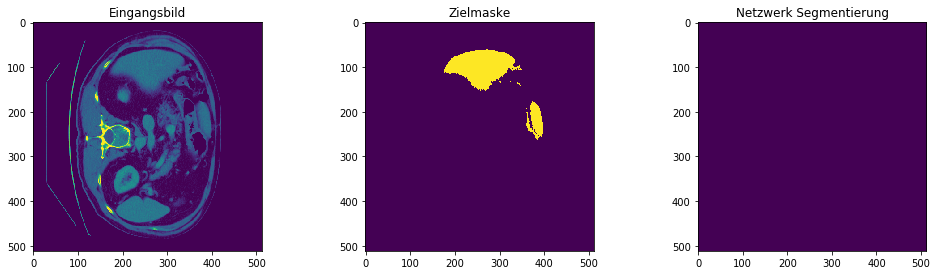

In [55]:
import numpy as np
#idx = np.random.randint(len(valliverdataset.images))
idx = 50
test_image = standardize(np.load(valliverdataset.images[idx]))
test_mask  = np.load(valliverdataset.masks[idx])

input_image = np.expand_dims(np.expand_dims(test_image, axis=0), axis=0)
prediction  = UNet(torch.from_numpy(input_image).type(torch.FloatTensor).to(device))
prediction  = prediction.cpu().detach().numpy()[0,0,:]

f,ax = plt.subplots(1,3)
ax[0].imshow(test_image)
ax[0].set_title('Eingangsbild')
ax[1].imshow(test_mask)
ax[1].set_title('Zielmaske')
ax[2].imshow(prediction)
ax[2].set_title('Netzwerk Segmentierung')
f.tight_layout()
f.set_size_inches(15,5)
plt.show()